In [ ]:
checkpoint_path: str='./lightning_logs/Everything_TS4+gaps_best/last.ckpt' # can be a glob pattern, in which case the last checkpoint is chosen
n_flow_through_times: int=2 # number of flow through times to simulate to determine long term behavior
n_intermediate_outputs: int=8 # number of intermediate outputs to use for the simulation
n_sim_pred_samples: int=5 # number of samples to use for the simulation
fast_dataloaders: bool=True # whether to use fast dataloaders (don't overwhelm memory with large models)
random_IC: bool=False # whether to use a random IC for the simulation

# Setup:

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as L
import torch.nn.functional as F
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')
torch.set_float32_matmul_precision('medium')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

from utils import *
from lightning_utils import *
import JHTDB_sim_op

import model_agnostic_BNN # the script is now fully compatible with the current model
from model_agnostic_BNN import get_BNN_pred_distribution, get_BNN_pred_moments, get_BNN_pred_mixture

L.seed_everything(0)

In [ ]:
from glob import glob
try: checkpoint_path = sorted(glob(checkpoint_path))[-1] # last is the most recent
except IndexError: raise FileNotFoundError(f'No checkpoint found at {checkpoint_path}') from None
print(f'{checkpoint_path=}')

# Load the Model:

In [ ]:
# create the posterior sampling wrapper class
from JHTDB_sim_op import POU_NetSimulator, PPOU_NetSimulator
from contextlib import contextmanager

class PredMomentsWrapper(PPOU_NetSimulator):
    n_moment_samples=1
    verbose=False
    def forward(self, x_inputs, **kwd_args):
        n_samples = type(self).n_moment_samples
        if n_samples>1:
            mu, sigma = get_BNN_pred_moments(super().forward, x_inputs, n_samples=n_samples,
                                             verbose=type(self).verbose, **kwd_args)
        else: mu, sigma = super().forward(x_inputs, **kwd_args)
        return mu, sigma
    
    @classmethod
    @contextmanager
    def enable_sampling(cls, n_samples: int, verbose: bool = False):
        try:
            cls.n_moment_samples = n_samples
            cls.verbose = verbose
            yield
        finally:
            cls.n_moment_samples = 1
            cls.verbose = False

In [ ]:
import sys
sys.path.append('./WNO/Version_2.0.0')
from wno3d_NS import WNO3d
from glob import glob

import utils
def load_model(path, device='cuda', VI_override_class=PPOU_NetSimulator, **kwd_args):
    ''' Wraps up all the nonsense involved in loading an inference model properly into one function. '''
    paths = glob(path)
    assert len(paths)==1, f'found these files: {paths}, but expected to find exactly one.'
    path = paths[0]
    print(f'loading model from path: {path}')
    
    try:
        print('loading VI model...')
        model = VI_override_class.load_from_checkpoint(path, **kwd_args)
    except Exception as e:
        try:
            print('loading deterministic model...')
            model = POU_NetSimulator.load_from_checkpoint(path, **kwd_args)
        except: raise

    model = model.to(device)
    model.eval()

    print(f'num model parameters: {utils.count_parameters(model):.5e}')

    # freeze everything
    for parameter in model.parameters():
        parameter.requires_grad=False
    print('done!')
    return model

# 'last.ckpt' comes after 'epoch*.ckpt' alphabetically (epoch*.ckpt is the "best long horizon model")
get_best_long_horizon_model = lambda ckpt_dir: sorted(glob(f'{ckpt_dir}/*.ckpt'))[0]

model = load_model(checkpoint_path, VI_override_class=PredMomentsWrapper)

## 3d Expert Partitions

In [ ]:
u0 = model.simulator.genIC().detach() # random IC
gating_weights, topk = model.gating_net(u0[None])
topk_sort_idx = torch.argsort(topk)
gating_weights, topk = gating_weights[:,topk_sort_idx], topk[topk_sort_idx]
gating_weights = gating_weights[0].cpu() # ditch batch dim & move to cpu
print(f'{gating_weights.shape=}')

In [ ]:
# add the zero expert weight
ones = torch.ones(1,*gating_weights.shape[1:], dtype=gating_weights.dtype, device=gating_weights.device)
zero_weight = ones - gating_weights.sum(axis=0)
gating_weights = torch.cat([zero_weight, gating_weights], axis=0)
print(f'{gating_weights.shape=}')

In [ ]:
from grid_figures import GridFigure
fig = GridFigure(f'3d Expert Partitions', y_title_vertical=False)

print('NOTE: expert #0 is also literally the "Zero Expert"')
for expert_i in range(gating_weights.shape[0]):
    fig.add_3d_row(gating_weights[expert_i], f'expert #{expert_i}', x_title_func=lambda t: f'z={t}',
                   img_getter=lambda array_3d, t: array_3d[:,:,t].T, time_samples=list(range(0,gating_weights.shape[-1],10)))
fig.show()

In [ ]:
# check if others are different? turns out the others are used a little bit
print('spatially averaged gating weights for each expert:', torch.vmap(torch.mean)(gating_weights).numpy())

# Data Loading:

In [ ]:
from JHTDB_data_loading import JHTDBDataModule, preload_dataset

# long horizon is explicit for legacy reasons to patch a previous bug
data_module = JHTDBDataModule.load_from_checkpoint(checkpoint_path, long_horizon=200, fast_dataloaders=fast_dataloaders)

In [ ]:
field_size = data_module.field_size
n_steps_total=4000//data_module.time_stride
intermediate_output_stride=n_steps_total//n_intermediate_outputs-1
print(f'{n_steps_total=}, {intermediate_output_stride=}')

In [ ]:
import numpy as np
def make_4d_sim_fig(sim_data, vel_comp_idx:int, prefix='', time_stride=intermediate_output_stride, 
                    num_z=4, vel_component_name = ['X','Y','Z'], show=True):
    from grid_figures import GridFigure
    fig = GridFigure(f'{prefix}3d Channel Flow: {vel_component_name[vel_comp_idx]} Velocity')
    sim_data = sim_data.cpu()
    for z in np.linspace(0, sim_data.shape[-2]-1, num=num_z, dtype=int):
        fig.add_3d_row(sim_data[vel_comp_idx,:,:,z], f'{z=}', x_title_func=lambda t: f't={t*time_stride}',
                       img_getter=lambda array_3d, t: array_3d[:,:,t].T, time_samples=list(range(sim_data.shape[-1])))
    if show: fig.show()
    return fig

x, y = data_module.dataset[0]
xy = torch.cat([x[...,None], y],axis=-1) # recombine!
make_4d_sim_fig(xy, 0, time_stride=data_module.time_stride, num_z=field_size[-1]//8)

### Here we load the DNS dataset tensor:

In [ ]:
# load the full simulation but then stride it to match the intermediate output stride of the learned simulations
real_channel_flow_full = real_channel_flow = data_module.load_full_dataset_field()
real_channel_flow = real_channel_flow[...,::intermediate_output_stride]

# Run Simulation:
This generalizes the case UQ and deterministic case (automatically taking epistemic samples if needed) 

In [ ]:
u0 = model.simulator.genIC(from_LES=True).detach() if random_IC else real_channel_flow[..., 0].to(model.device)
with torch.inference_mode():
    with PredMomentsWrapper.enable_sampling(n_sim_pred_samples, verbose=True):
        sim_steps_extra = model(u0, n_steps=n_steps_total*n_flow_through_times,
                                intermediate_output_stride=intermediate_output_stride)

# TODO: think of better way to do this?
def post_process_sim_steps(sim_steps_extra):
    sim_steps_extra = sim_steps_extra.cpu()
    sim_steps = sim_steps_extra[...,:n_intermediate_outputs+1] # extra regular simulation
    sim_steps_2nd = sim_steps_extra[...,n_intermediate_outputs:n_intermediate_outputs*2+1] # extra regular simulation (2nd flow through time)
    sim_steps_extra = sim_steps_extra[...,::n_flow_through_times] # compress for display
    assert sim_steps.shape==sim_steps_2nd.shape==sim_steps_extra.shape
    return sim_steps_extra, sim_steps, sim_steps_2nd

# handle uq
if type(sim_steps_extra) is tuple:
    assert len(sim_steps_extra)==2
    sim_steps_extra, sim_steps_uq_extra = sim_steps_extra # keep them seperate so later code works
    sim_steps_uq_extra, sim_steps_uq, sim_steps_uq_2nd = post_process_sim_steps(sim_steps_uq_extra)
sim_steps_extra, sim_steps, sim_steps_2nd = post_process_sim_steps(sim_steps_extra)

## Display Simulation:

In [ ]:
print(f'{u0.shape=}\n{real_channel_flow.shape=}\n{sim_steps.shape=}\n{sim_steps_extra.shape=}\n(uq variables have the same shape))')

In [ ]:
def create_all_simulation_figs(predicted_sim_steps, true_sim_steps=None, predicted_prefix='Learned ', true_prefix='DNS ',
                               time_stride=intermediate_output_stride, shared_color_bar=True):
    for i in range(3):
        if true_sim_steps is not None:
            print('#'*50 + f'\n{true_prefix}Simulation:')
            true_fig = make_4d_sim_fig(true_sim_steps, i, time_stride=time_stride, prefix=true_prefix)
        print('#'*50 + f'\n{predicted_prefix}Simulation:')
        fig = make_4d_sim_fig(predicted_sim_steps, i, time_stride=time_stride, prefix=predicted_prefix, show=False)
        if true_sim_steps is not None and shared_color_bar: fig.copy_color_bar(true_fig)
        fig.show()

create_all_simulation_figs(sim_steps, real_channel_flow)

In [ ]:
try:
    tshow(sim_steps_uq_extra)
    create_all_simulation_figs(sim_steps_extra, sim_steps_uq_extra*np.sqrt(2/np.pi), true_prefix='UQ ', 
                               time_stride=intermediate_output_stride*n_flow_through_times, shared_color_bar=False)
except NameError:
    create_all_simulation_figs(sim_steps_extra, time_stride=intermediate_output_stride*n_flow_through_times)

In [ ]:
try:
    vmean = torch.vmap(torch.mean)
    plt.plot(vmean(sim_steps_uq_extra.swapaxes(0,-1)))
    plt.title('UQ vs time')
    plt.show()
except NameError: pass

## Cross Correlation (checking for trivial advection):

In [ ]:

def cross_correlation_plot(pred_flow, real_channel_flow, title=''):
    ''' This code assumes you have 2 numpy arrays loaded in memory:
    pred_samples with shape, (3,Nx,Ny,Nz,times)
    real_channel_flow with shape, (3,Nx,Ny,Nz,times) '''
    p1 = pred_flow[...,0]
    p2 = pred_flow[...,-1]
    r1 = real_channel_flow[...,0]
    r2 = real_channel_flow[...,-1]
    plt.plot(np.fft.irfft((np.fft.rfft(r1-r1.mean(1)[:,None],axis=1).conj()*np.fft.rfft(r2-r2.mean(1)[:,None],axis=1)).mean((0,2,3))),label='true')
    plt.plot(np.fft.irfft((np.fft.rfft(p1-p1.mean(1)[:,None],axis=1).conj()*np.fft.rfft(p2-p2.mean(1)[:,None],axis=1)).mean((0,2,3))),label='model')
    plt.legend()
    plt.title('Flow Cross-Correlation: '+title)
    plt.show()
assert tuple(sim_steps.shape)==tuple(real_channel_flow.shape)
print(f'real_channel_flow.shape={sim_steps.shape=}')

In [ ]:
divisors = [8,4,2,1]
assert sim_steps_2nd.shape[-1] == real_channel_flow.shape[-1]
for divisor in divisors:
    if real_channel_flow.shape[-1] % divisor > 0:
        divisor = real_channel_flow.shape[-1]//(real_channel_flow.shape[-1]//divisor) # correct divisor for plot title
    print(f'{divisor=}')
    cross_correlation_plot(sim_steps_2nd[...,:sim_steps_2nd.shape[-1]//divisor], 
                            real_channel_flow[...,:sim_steps_2nd.shape[-1]//divisor], 
                            title=f'$T_0$ vs $T_0+1/{divisor}$')


In [ ]:
# first flow through time
cross_correlation_plot(sim_steps, real_channel_flow, title='First flow through time only')

# Ravi's Verbatim Flow Statistics:

## Ravi's Energy Spectrum Equations:

"A good place to start is looking at the energy spectrum which describes how the energy is distributed across wavelengths.
Here’s how to get it:" <br>
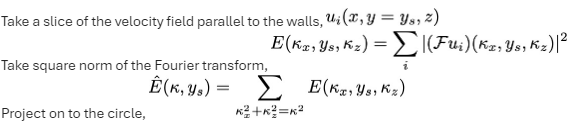

## Getting Samples?
TODO: maybe get these samples earlier instead of getting moments?

In [ ]:
if isinstance(model, PPOU_NetSimulator):
    with torch.inference_mode():
        # GOTCHA: this might give biased results compared to starting from the true IC & simulating double flow through time
        u0 = real_channel_flow[..., -1].to(model.device)
        pred_samples = get_BNN_pred_distribution(model, u0, n_samples=n_sim_pred_samples, n_steps=n_steps_total, intermediate_output_stride=intermediate_output_stride)
        pred_samples = torch.distributions.Normal(*pred_samples).sample().cpu()
else: pred_samples = sim_steps_2nd[None]
print(f'{pred_samples.shape=}')

## Comprehensive Flow Stats Plots:

In [ ]:
'''
This code assumes you have 2 numpy arrays loaded in memory:
    pred_samples with shape, (samples,3,Nx,Ny,Nz,times) (from 1 to 2 flow through times, it can be any flow through time though)
    real_channel_flow with shape, (3,Nx,Ny,Nz,times)
'''

import numpy as np
import matplotlib.pyplot as plt
def E(u):
    uh = np.fft.rfftn(u,axes=[0,2])
    return np.sum(np.abs(uh)**2,axis=-1)
def npmap(f,a):
    return np.array(list(map(f,a)))
def E1d(Lx,Ly,Lz,epsilon_multiplier,nk,u):
    '''
    arguments:
        Lx,Ly,Lz: domain lengths
        epsilon_multiplier: for width of ring to project to point
        nk: number of points along radius to project on to
        u: input function
    output:
        energy spectrum from u. First axis is the energy spectrum. Second is y coordinate
    '''
    nx,ny,nz = u.shape[0:-1]
    kx = np.fft.fftfreq(nx,d=Lx/nx)
    kz = np.fft.rfftfreq(nz,d=Lz/nz)
    dk = np.sqrt(kx[1]**2 + kz[1]**2)
    epsilon = epsilon_multiplier*dk
    Kxz = np.stack(np.meshgrid(kx,kz,indexing='ij'),axis=-1)
    K = np.sqrt(Kxz[...,0]**2 + Kxz[...,1]**2)
    k = np.linspace(0,min(np.max(kx),np.max(kz)),nk)
    Eu = E(u)
  
    return k,2.*np.transpose(npmap(
        lambda j:npmap(
            lambda ki:np.sum(Eu[:,j][np.abs(K-ki)<epsilon]),
            k),
        np.arange(ny)))
    
def cross_correlation(pred_samples,real_channel_flow):
    p1 = pred_samples.mean(axis=0)[...,0]
    p2 = pred_samples.mean(axis=0)[...,-1]
    
    r1 = real_channel_flow[...,0]
    r2 = real_channel_flow[...,-1]
    return p1,p2,r1,r2


#real_channel_flow.shape==(3,Nx,Ny,Nz,times)
#pred_samples.shape==(samples,3,Nx,Ny,Nz,times)
def plot_1dDiagnostics(pred_samples,real_channel_flow):
    # Dwyer: I fixed this so it doesn't depend on the number of timesteps (-1 is the last timestep)
    k,EE = E1d(8*np.pi,2.,4*np.pi,epsilon_multiplier=1.0*np.mean(data_module.stride),nk=30,u=torch.swapaxes(real_channel_flow,4,0)[-1])
    Es = []
    for samp in pred_samples: # Dwyer: I fixed this so it doesn't depend on the number of samples
        zzz1 = np.moveaxis(np.asarray(samp[...,-1]),0,-1)
        k,EE1 = E1d(8*np.pi,2.,4*np.pi,epsilon_multiplier=1.0*np.mean(data_module.stride),nk=30,u=zzz1)
        Es.append(EE1)
    Es=np.array(Es)
    y_plane_index = real_channel_flow.shape[2]//2 # Dwyer: should be the midpoint
    mu = np.mean(Es[...,y_plane_index],0)
    std = np.std(Es[...,y_plane_index],0)
    y = np.loadtxt('y.txt') # Dwyer: we need to interpolate this to the number of y points in the flow
    y = np.interp(np.linspace(0,1,real_channel_flow.shape[2]), np.linspace(0,1,len(y)), y) # interp(x, xp, fp)
    fig,ax = plt.subplots(1,4,figsize=(8,2),sharex='col',sharey='col')
    ax[0].loglog(k[2:],EE[2:,y_plane_index],'C1') # NOTE: C1 & C2 are colors
    ax[0].loglog(k[2:],mu[2:],'--k')
    ax[0].fill_between(k[2:],mu[2:]-2*std[2:],mu[2:]+2*std[2:])
    ax[0].loglog(k[4:],3e4*k[4:]**(-5./3.),'C2')
    ax[0].set_ylim(2e3,5e4)
    ax[0].set_ylabel(r'$E(\kappa)$')
    xz_plane_index = 10 # Dwyer: why 10? <-- apparently arbitrary?
    res = pred_samples[:,:,xz_plane_index,:,xz_plane_index,-1].mean(1)
    mu = res.mean(0)
    std = res.std(0)
    ax[1].plot(y,real_channel_flow[:,xz_plane_index,:,xz_plane_index,-1].mean(0),'C1')
    # for i in range(10):
    ax[1].plot(y,mu,'--k')
    ax[1].fill_between(y,mu-2*std,mu+2*std)
    ax[1].set_ylabel('$u_{1}$')
    ax[2].set_ylabel('$u_{rms}$')
    res = np.sqrt(pred_samples[:,:,xz_plane_index,:,xz_plane_index,-1].var(1))
    mu = res.mean(0)
    std = res.std(0)
    ax[2].plot(y,np.sqrt(real_channel_flow[:,xz_plane_index,:,xz_plane_index,-1].var(0)),'C1')
    # for i in range(10):
    ax[2].plot(y,mu,'--k')
    ax[2].fill_between(y,mu-2*std,mu+2*std)
    p1,p2,r1,r2 =cross_correlation(pred_samples,real_channel_flow)
    ax[3].plot(np.fft.irfft((np.fft.rfft(r1-r1.mean(1)[:,None],axis=1).conj()*np.fft.rfft(r2-r2.mean(1)[:,None],axis=1)).mean((0,2,3))),'C1',label='true')
    ax[3].plot(np.fft.irfft((np.fft.rfft(p1-p1.mean(1)[:,None],axis=1).conj()*np.fft.rfft(p2-p2.mean(1)[:,None],axis=1)).mean((0,2,3))),'--k',label='model')
    plt.legend()
    ax[0].set_xlabel('$\kappa$')
    ax[1].set_xlabel('$y$')
    ax[2].set_xlabel('$y$')
    ax[3].set_xlabel('$x/\Delta x$')
    ax[3].set_ylabel('$u(0) \star u(T)$')
    fig.tight_layout()

plot_1dDiagnostics(pred_samples,real_channel_flow)
plt.show()

# Bayesian Model Validation:

In [ ]:
if not isinstance(model, PPOU_NetSimulator):
    from utils import StopExecution
    raise StopExecution

In [ ]:
utils.nvidia_smi(verbose=True)

## Calibration Checks:

In [ ]:
data_module.setup() # preload
val_loader_small_batch = data_module.val_dataloader(batch_size=2)['val']

In [ ]:
L.seed_everything(0)
cov_calc = model_agnostic_BNN.CoverageCalculator(model, val_loader_small_batch, 15)
del val_loader_small_batch

In [ ]:
cov_calc.plot_truth_quantile_hist()

In [ ]:
approx_ECE = cov_calc.calibration_curve()

In [ ]:
ECE = cov_calc.get_ECE()

## Posterior-Predictive-Log-Likelihood

In [ ]:
val_dataloaders = data_module.val_dataloader()
x,y = next(iter(val_dataloaders['long_horizon']))
print(f'{x.shape=}, {y.shape=}')

In [ ]:
L.seed_everything(0)
model = model.cuda() # must be on GPU!

import model_agnostic_BNN
LPPC_val = model_agnostic_BNN.log_posterior_predictive_check(model, val_dataloaders['val'])
print(f'{LPPC_val=}')
LPPC_val_long = model_agnostic_BNN.log_posterior_predictive_check(model, val_dataloaders['long_horizon'], n_steps=data_module.long_horizon-1)
print(f'{LPPC_val_long=}')

## Regular Model Metrics with Posterior Averaging

In [ ]:
L.seed_everything(0)
with PredMomentsWrapper.enable_sampling(25):
    trainer = L.Trainer()
    trainer.validate(model=model, dataloaders=val_dataloaders)
del val_dataloaders

In [ ]:
import utils
print(f'num model parameters: {utils.count_parameters(model):.5e}')